# EDA
- せっかくだから、Kernel見ないで全部やる（eda、前処理、学習、検証)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2
from ptitprince import RainCloud
from pandarallel import pandarallel
from datetime import datetime as dt
from pandas.plotting import autocorrelation_plot
pandarallel.initialize()

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
INPUT = '../input/'

In [5]:
train = pd.read_csv(INPUT+'train.csv')
test = pd.read_csv(INPUT+'test.csv')
features = pd.read_csv(INPUT+'features.csv')
stores = pd.read_csv(INPUT+'stores.csv')
sample = pd.read_csv(INPUT+'sampleSubmission.csv')

# とりあえず見てみる
- 欠損値なし
- カラム少ねえ
- Date以外数値にしてくれてる(True==1,False==0)
- データ件数結構ある ->決定木系で実験いっぱい回したほうが良さげ？？
- len(train):len(test) = 4:1
- targetがマイナスまである
- Storeの出現回数にそこまでばらつきなし
- Deptの出現回数には結構ばらつきある
- Holidayの割合は一緒くらい

In [ ]:
train

In [ ]:
train.info()

In [ ]:
train.describe().T

In [ ]:
train['IsHoliday'].mean()

In [ ]:
sns.histplot(data=train,x='Store')

In [ ]:
sns.histplot(data=train,x='Dept')

In [ ]:
test

In [ ]:
test.info()

In [ ]:
test.describe().T

In [ ]:
sns.histplot(data=test,x='Store')

In [ ]:
sns.histplot(data=test,x='Dept')

In [ ]:
test['IsHoliday'].mean()

## targetの分布を見る
- カイ二乗分布っぽい
- 正の外れ値ヤバイ　->件数かなり少ないし除くべき？？
- わかりにくいけどマイナスも1300件くらいある
- これなんでRMSLEにしなかったんだろう？？(大きい値を正確に予測してほしかった？？)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
RainCloud(data=train, y='Weekly_Sales', orient='h', ax=ax)
ax.grid()

In [ ]:
train[['Weekly_Sales']].query('Weekly_Sales < 0')

In [ ]:
#Weekly_Salesの正のやつで対数とってみる
train_log = np.log1p(train[['Weekly_Sales']].query('Weekly_Sales>=0'))

fig, ax = plt.subplots(figsize=(8, 5))
RainCloud(data=train_log, y='Weekly_Sales', orient='h', ax=ax)
ax.grid()

# trainとtestの差分を見る
- trainで未来のtestを予測するのか。今気づいた。(timeseriessplitしないと大変なことになる)
- Store,Deptはunseenなやつなし
- 時間があればStore,Dept毎にモデル作っても良さそう
- Store,Deptは分布も一緒だから気にしないで良い

In [ ]:
columns = test.columns
n_figs = len(columns)
n_cols = 4
n_rows = 1

fig, axes = plt.subplots(figsize=(n_cols * 3, n_rows * 3), ncols=n_cols, nrows=n_rows)

for c, ax in zip(columns, axes.ravel()):
    venn2(
        subsets=(set(train[c].unique()), set(test[c].unique())),
        set_labels=('Train', 'Test'),
        ax=ax
    )
    ax.set_title(c)

fig.tight_layout()

In [ ]:
sns.distplot(x=train['Store'],kde=True,norm_hist=True)
sns.distplot(x=test['Store'],kde=True,norm_hist=True)

In [ ]:
sns.distplot(x=train['Dept'],kde=True,norm_hist=True)
sns.distplot(x=test['Dept'],kde=True,norm_hist=True)

# 時系列で可視化する
- 週ごとの合計売上見ると、一年毎のトレンドがある
- DeptでもStoreでも一年ごとのトレンド有り
- Store毎に得意なDeptがある
- 金曜日にしか記録とってなかった
- クリスマスめっちゃ売上良い-特別な処理するべき？
- Deptは割とばらついてるので、Dept毎にモデル作っても良さそう
- 年ごとの相関強すぎ。一年前の売上提出するだけでそこそこ良い精度出そう

In [6]:
train['Date'] = train['Date'].parallel_apply(lambda x:dt.strptime(x,'%Y-%m-%d'))
test['Date'] = test['Date'].parallel_apply(lambda x:dt.strptime(x,'%Y-%m-%d'))

train['Year'] = train['Date'].dt.year
train['Week'] = train['Date'].dt.week
test['Year'] = test['Date'].dt.year
test['Week'] = test['Date'].dt.week

ipykernel_launcher:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
ipykernel_launcher:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


<AxesSubplot:xlabel='Date', ylabel='Store'>

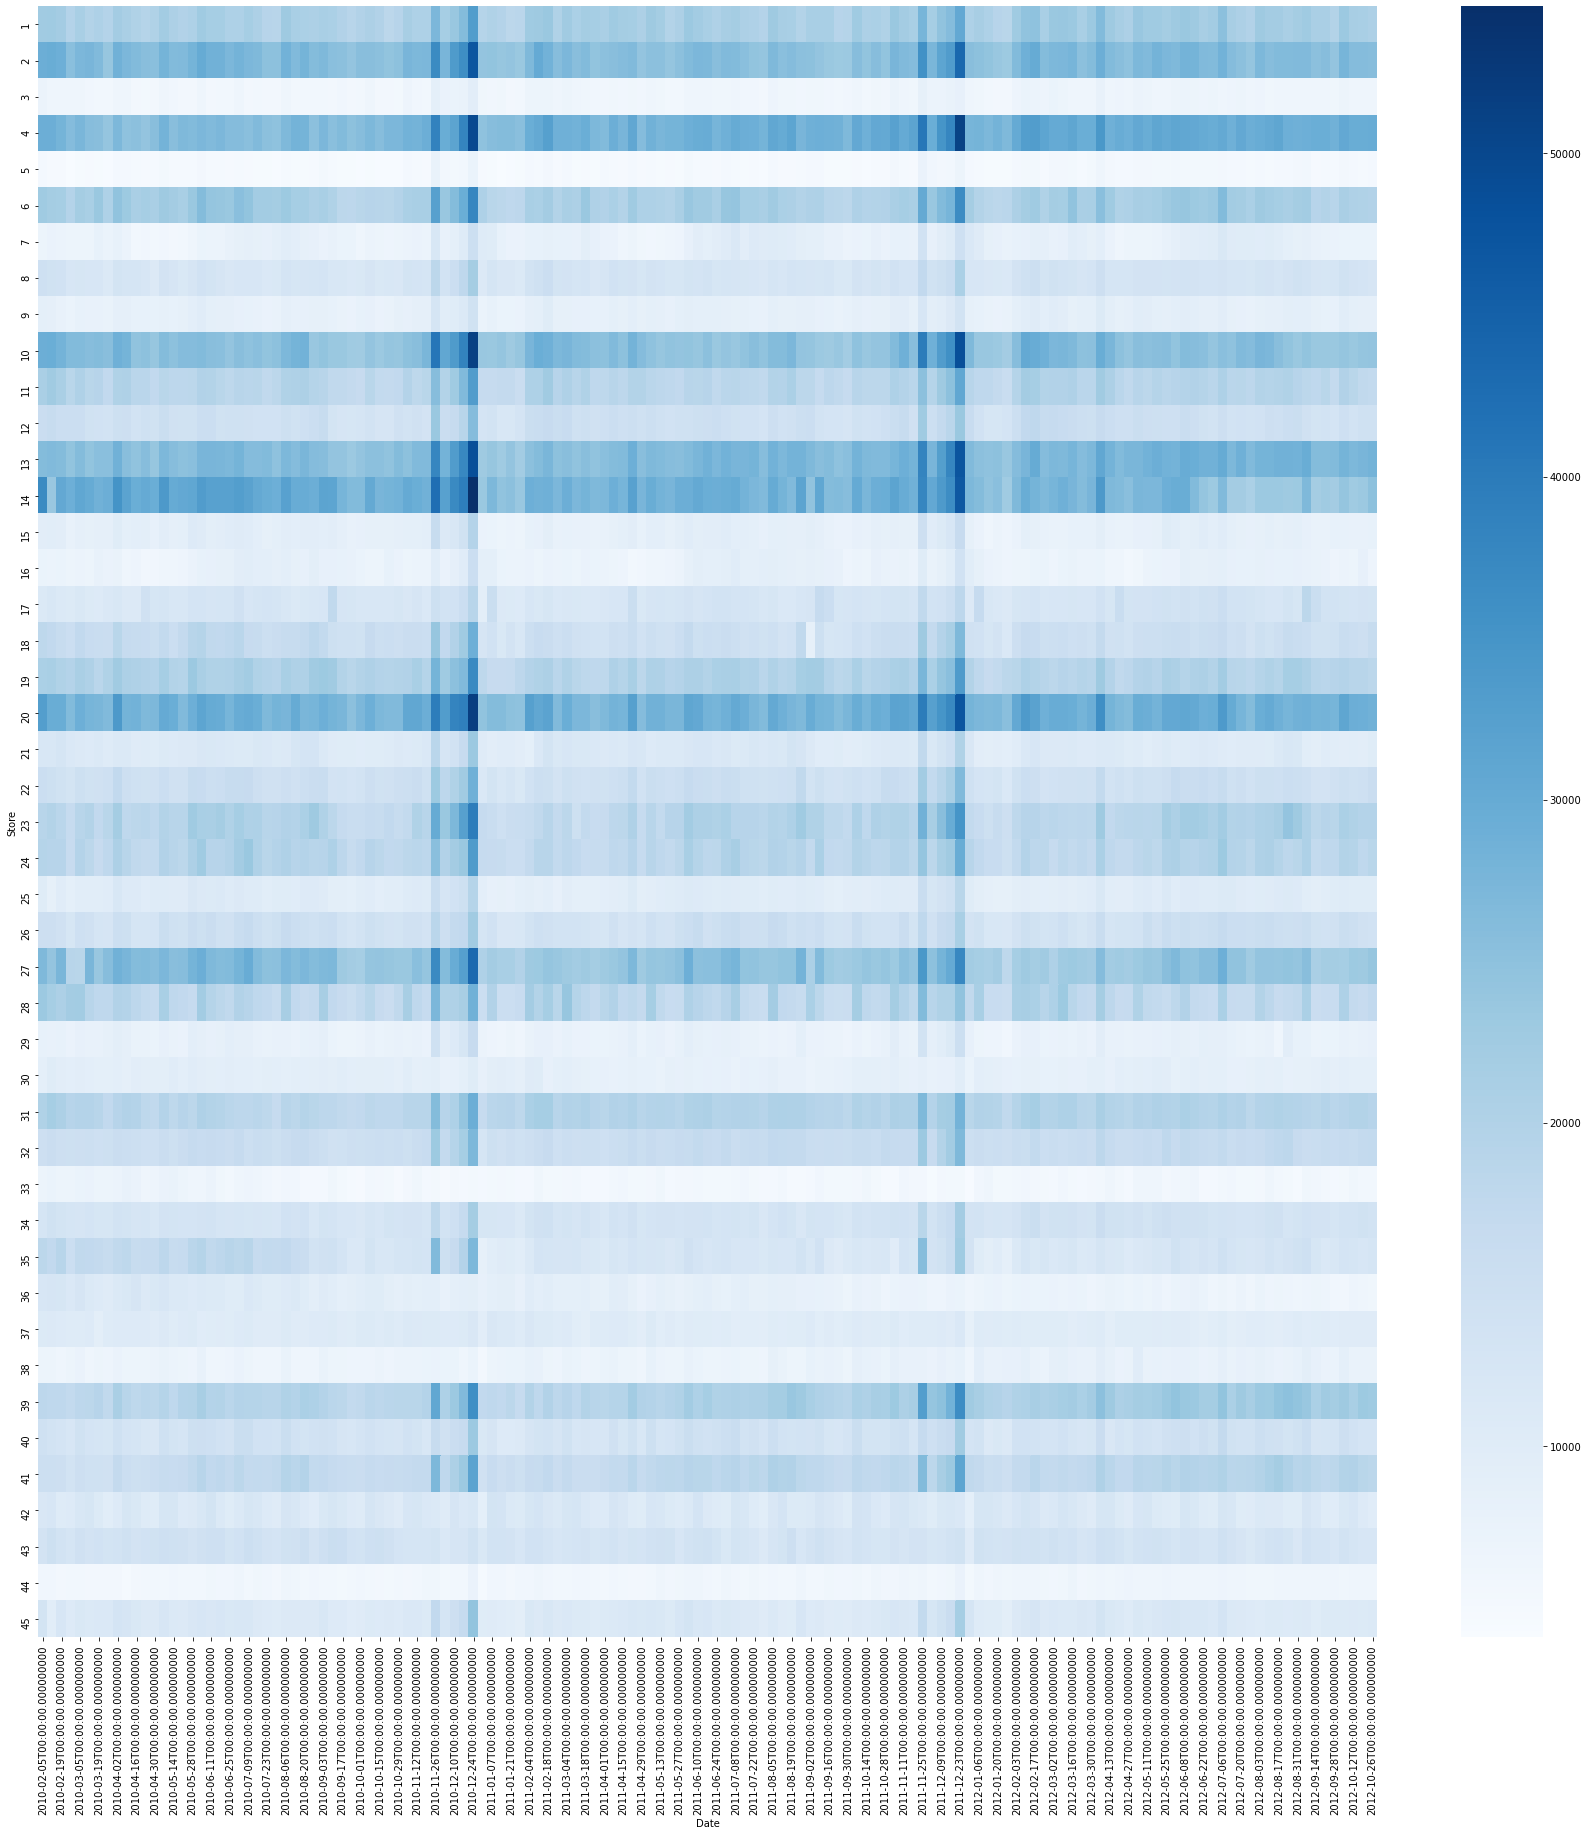

In [7]:
#Store毎の時系列
pivot = pd.pivot_table(data=train,columns='Date',index='Store',values='Weekly_Sales')
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(pivot,ax=ax,cmap='Blues')

<AxesSubplot:xlabel='Date', ylabel='Dept'>

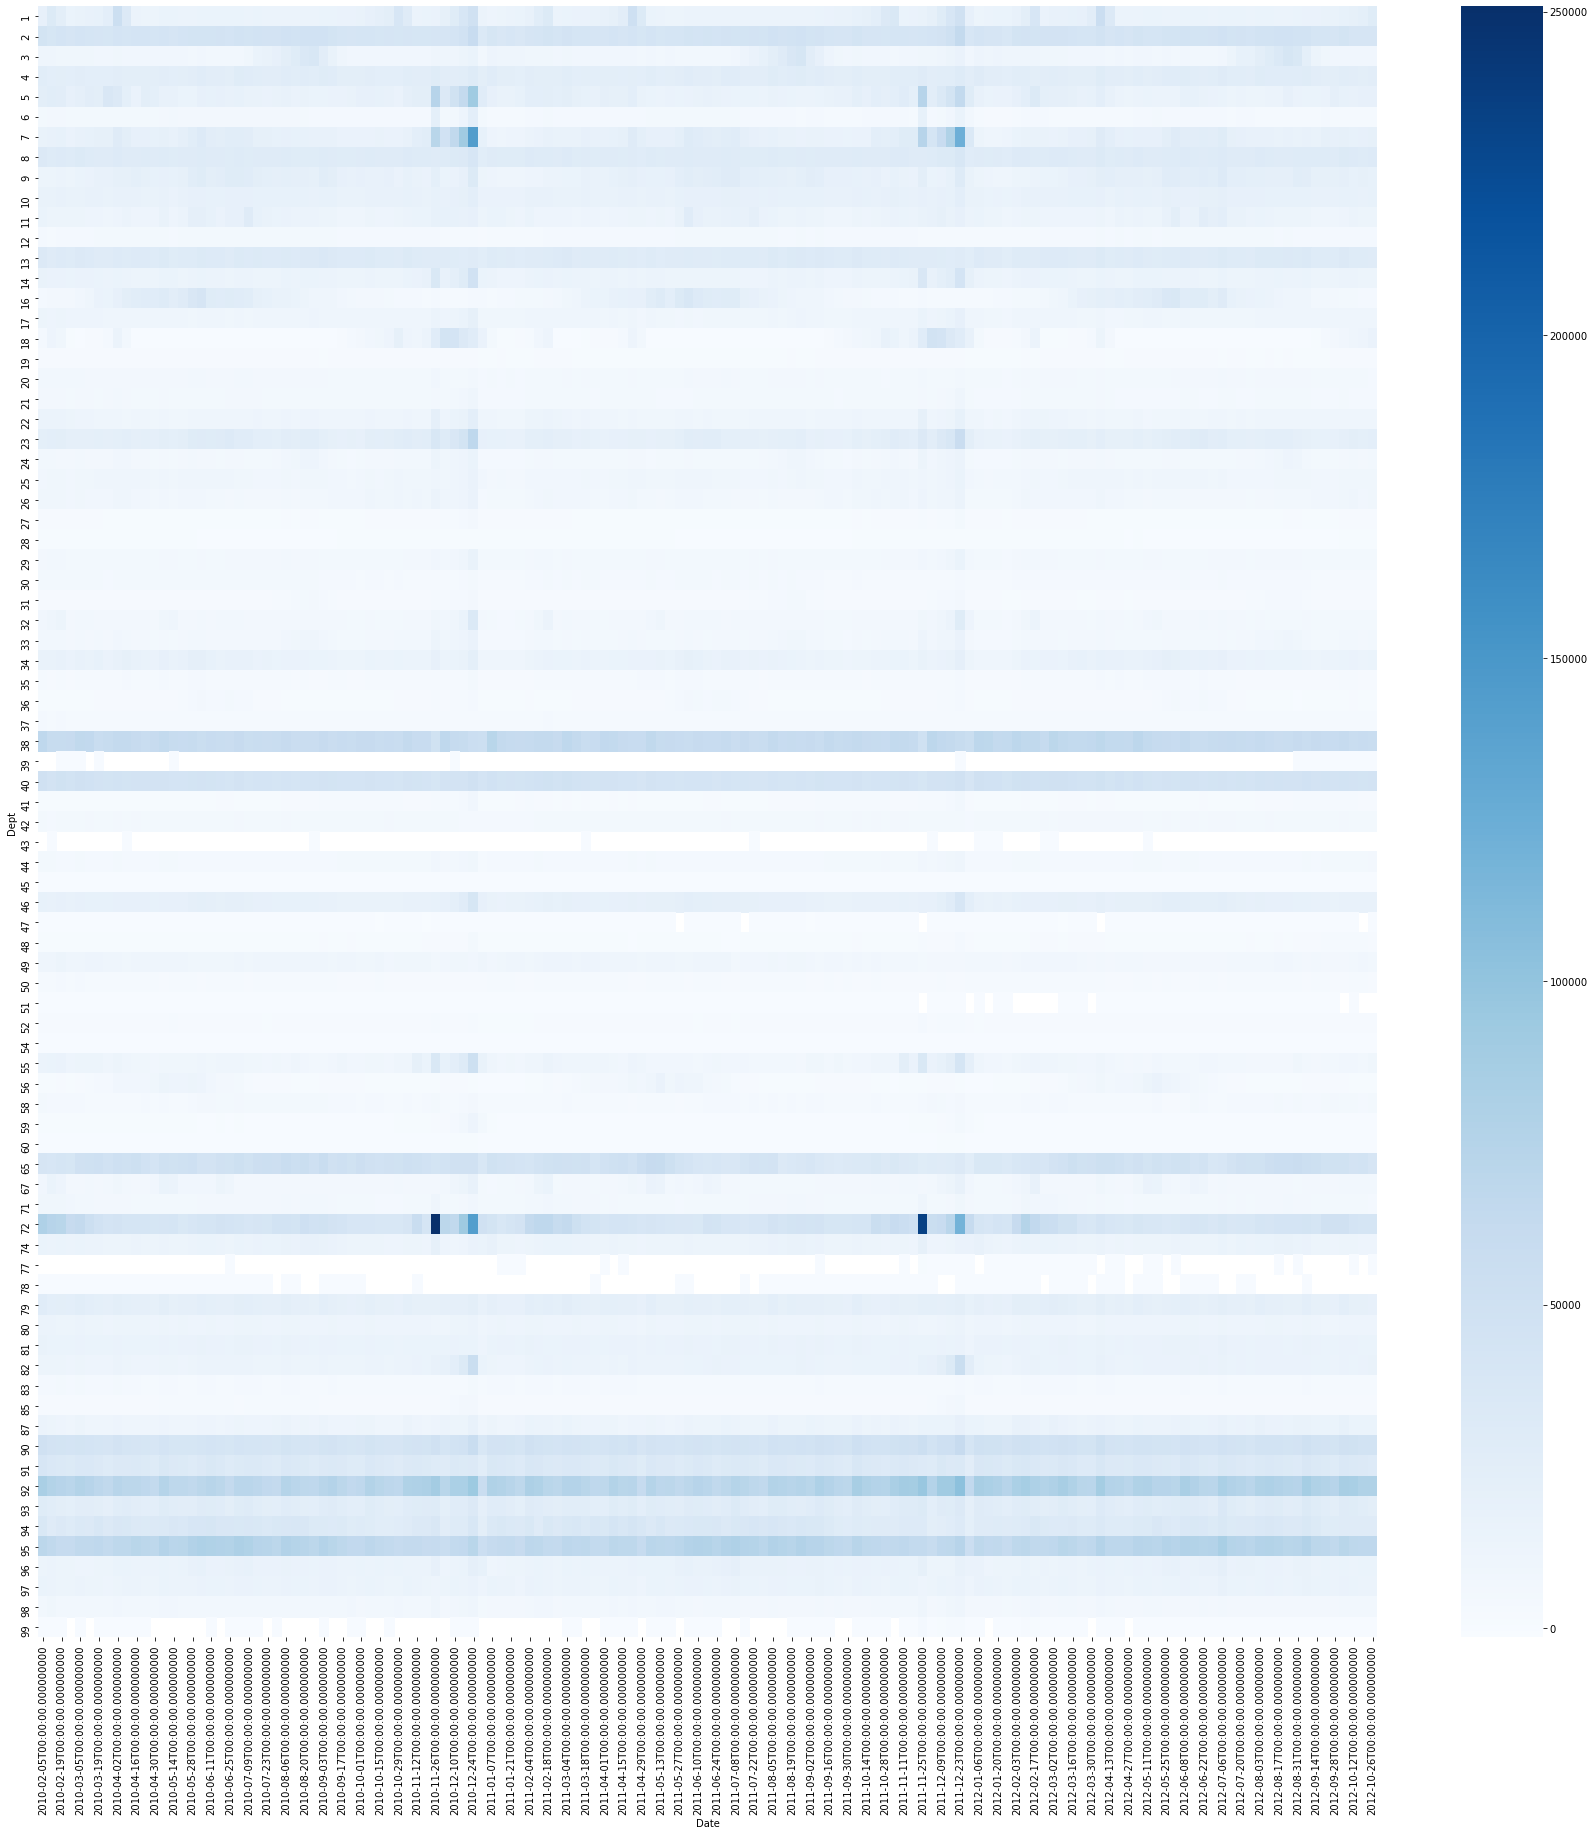

In [8]:
#Dept毎の売上
pivot = pd.pivot_table(data=train,columns='Date',index='Dept',values='Weekly_Sales')
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(pivot,ax=ax,cmap='Blues')

<AxesSubplot:xlabel='Date', ylabel='0'>

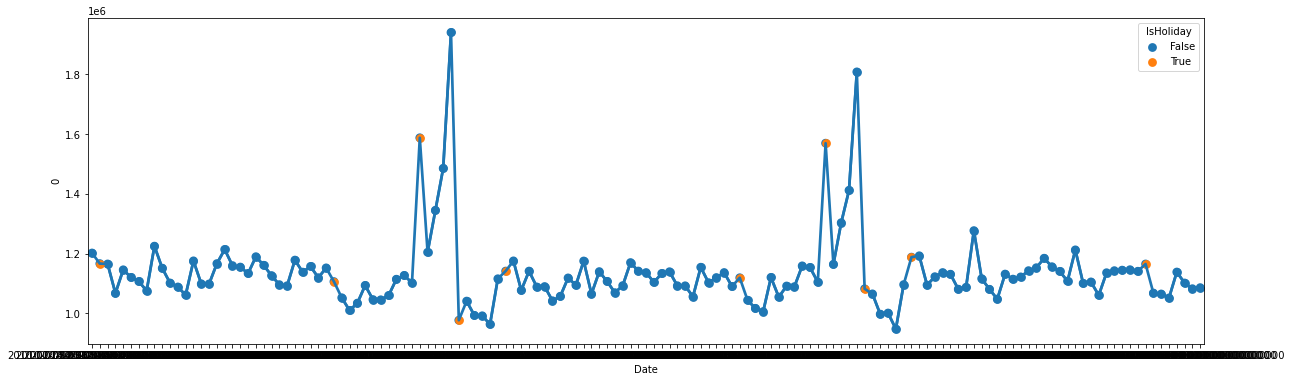

In [9]:
#合計の時系列、うまいやり方がわからない教えてほしいです。。。
fig, ax = plt.subplots(figsize=(20, 6))
sum_sales = pd.DataFrame(pivot.sum())
sum_sales['IsHoliday'] = train.groupby('Date')['IsHoliday'].mean()
sum_sales.reset_index(inplace=True)
sns.pointplot(data=sum_sales,x='Date',y=0,hue='IsHoliday')
sns.pointplot(data=sum_sales,x='Date',y=0)

/home/yuuki/anaconda3/envs/tf/lib/python3.7/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/yuuki/anaconda3/envs/tf/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/yuuki/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

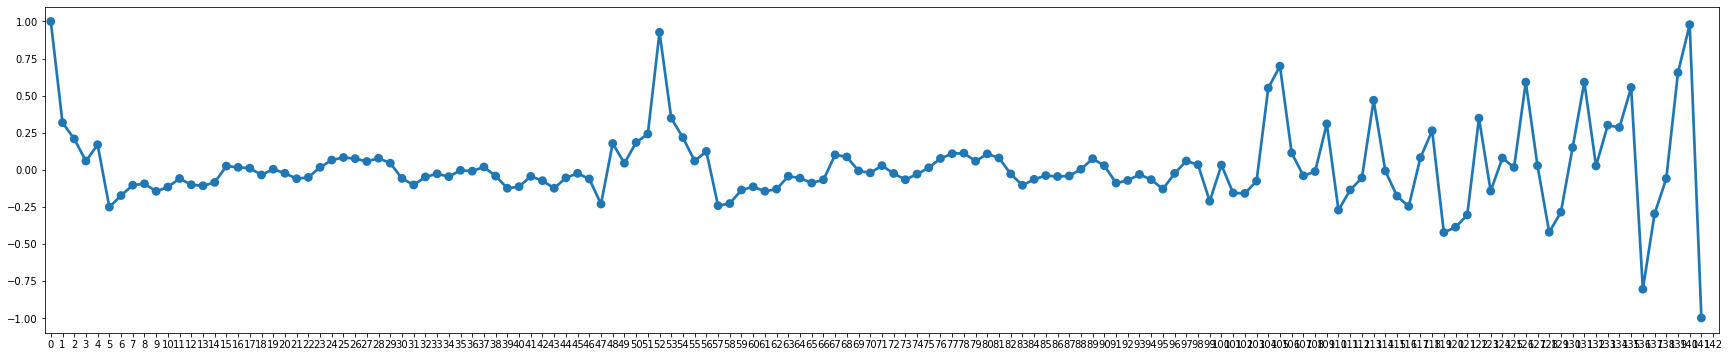

In [26]:
#自己相関
fig = plt.figure(figsize=(30,6))
x = sum_sales['Date']
y = sum_sales[0]
autocorrs = [y.autocorr(lag=lag) for lag in range(len(x))]
sns.pointplot(list(range(len(x))),autocorrs)

In [ ]:
#時系列じゃないけど、Dept,Storeのpivot_table見る
#Store毎に得意なDeptがありそう
pivot = pd.pivot_table(data=train,columns='Dept',index='Store',values='Weekly_Sales')
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(pivot,ax=ax,cmap='Blues')

In [ ]:
train['Day'] = train['Date'].parallel_apply(lambda x:x.strftime('%A'))
train['Month'] = train['Date'].parallel_apply(lambda x:int(x.strftime('%m')))

In [ ]:
#Storeの月ごと売上
pivot = pd.pivot_table(data=train,columns='Month',index='Store',values='Weekly_Sales')
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(pivot,ax=ax,cmap='Blues')

In [ ]:
#月合計の時系列
fig, ax = plt.subplots(figsize=(20, 6))
pivot.sum().plot(ax=ax)
ax.grid()
ax.set_title('Weekly_Salse_sum_by_Month')
fig.tight_layout()

In [ ]:
#週ごとの合計時系列
sales = pd.DataFrame(train.groupby(['Year','Week'])['Weekly_Sales'].sum()).reset_index()
fig = plt.figure(figsize=(20,10))
sns.pointplot(data=sales,x='Week',y='Weekly_Sales',hue='Year')
plt.title('Compair Weekly_Sales')

In [ ]:
print(pd.pivot_table(sales,index='Week',columns='Year',values='Weekly_Sales').corr())

In [ ]:
#Storeの曜日ごと売上
pivot = pd.pivot_table(data=train,columns='Day',index='Store',values='Weekly_Sales')
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(pivot,ax=ax,cmap='Blues')

# EDAまとめ
- 時系列で見たときの動きは全体的に一緒。というか一年ごとの相関強すぎる
- CVの切り方難しい、LightGBMならをカテゴリとみなして適当にやってもどうにかしてくれるか？？
- Model  
    1.Store,DeptをEmbeddingしてTransformerかLSTM(実装大変、時間かかる、精度出そう、過去の情報使いまくりで強そう)  
        - トレンドが長めに見えるからTransformerのほうが強そう  
    2.Dateを何周目という特徴にしてLightGBM(実装楽、時間そこそこ、精度そこそこ,過去の情報が上手く使えなさそう？)  
    3.統計モデル(ARMA等)も強そう。(実装初めて、計算早そう、精度わからん)  
    4.TimeSeriesKnnとかも良さげ
- 特徴量 
    - Month,何週目か
    - 移動平均
    - 自己相関
    - 自己変化率
    - n期前との差分
    - 月ごとのSum_Sales
    - クリスマスとかデカ目のイベントはフラグ立てる

In [ ]:
test['']